In [1]:
import os
import numpy as npw
import pandas as pd
import scanpy as sc
import liana as li
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# TODO: move such functions to a common utils folder
from classification.prep_utils import filter_samples
from classification.classify_utils import INVERSE_FUN

/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:205: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:304: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [3]:
from classification.processer import DatasetHandler

In [4]:
interactions = pd.read_csv('ct_interactions.csv')

(array([273.,  91.,  81.,  60.,  71.,  69.,  81.,  85.,  90.,  98.,  91.,
        104.,  76.,  77.,  53.,  55.,  47.,  33.,  38.,  38.,  31.,  32.,
         27.,  24.,  21.,  16.,  17.,  22.,  13.,   6.,  11.,   7.,  13.,
          2.,   8.,   5.,   4.,   5.,   4.,   5.,   1.,   1.,   1.,   4.,
          2.,   2.,   1.,   0.,   1.,   2.]),
 array([0.        , 0.09780448, 0.19560896, 0.29341344, 0.39121792,
        0.4890224 , 0.58682688, 0.68463136, 0.78243584, 0.88024032,
        0.9780448 , 1.07584928, 1.17365376, 1.27145824, 1.36926272,
        1.4670672 , 1.56487168, 1.66267616, 1.76048064, 1.85828512,
        1.9560896 , 2.05389408, 2.15169856, 2.24950304, 2.34730752,
        2.445112  , 2.54291648, 2.64072096, 2.73852544, 2.83632992,
        2.9341344 , 3.03193888, 3.12974336, 3.22754784, 3.32535232,
        3.4231568 , 3.52096128, 3.61876576, 3.71657024, 3.81437472,
        3.9121792 , 4.00998368, 4.10778816, 4.20559264, 4.30339712,
        4.4012016 , 4.49900608, 4.59681056, 4.

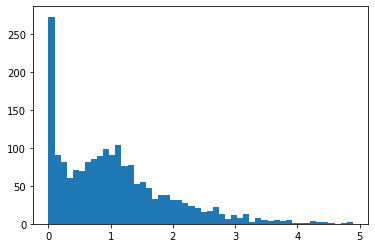

In [5]:
lr_nmf = pd.read_csv(os.path.join('kuppe_visium', 'results', 'lr_loadings.csv'), index_col=0)
# pivot longer
lr_nmf = lr_nmf.reset_index().melt(id_vars='index', var_name='factor', value_name='loading')
plt.hist(lr_nmf['loading'], bins=50)

In [6]:
# keep interactions with loading > 0.5 in any factor
lr_nmf = lr_nmf.query('loading > 0.5')
# separete by ^ into ligand and receptor
lr_nmf['ligand'] = lr_nmf['index'].str.split('^').str[0]
lr_nmf['receptor'] = lr_nmf['index'].str.split('^').str[1]
resource = lr_nmf[['ligand', 'receptor']].drop_duplicates()

Dataset params

In [7]:
dataset_name = 'kuppe'
ds = DatasetHandler('kuppe')
dataset_info = ds.dataset_params['kuppe']
defaults = ds.dataset_params['defaults']

In [8]:
dataset_name = dataset_name
groupby = 'cell_type_original' # NOTE: the same cell types but readable
sample_key = dataset_info.get('sample_key', defaults['sample_key'])
condition_key = dataset_info.get('condition_key', defaults['condition_key'])
min_cells_per_sample = dataset_info.get('min_cells_per_sample', defaults['min_cells_per_sample'])
sample_zcounts_max = dataset_info.get('sample_zcounts_max', defaults['sample_zcounts_max'])
sample_zcounts_min = dataset_info.get('sample_zcounts_min', defaults['sample_zcounts_min'])
min_cells = dataset_info.get('min_cells', defaults['min_cells'])
min_samples = dataset_info.get('min_samples', defaults['min_samples'])
use_raw = dataset_info.get('use_raw', defaults['use_raw'])
change_var_to = dataset_info.get('change_var_to', defaults['change_var_to'])
conditions_to_keep = dataset_info.get('conditions_to_keep', defaults['conditions_to_keep'])
n_factors = dataset_info.get('n_factors', defaults['n_factors'])

Process Full Dataset

In [11]:
adata = sc.read_h5ad(os.path.join('classification', 'data', 'kuppe.h5ad'), backed='r')

In [12]:
adata.obs[[condition_key, sample_key]].drop_duplicates().groupby(condition_key).count()

,sample
patient_group,
fibrotic,5
ischemic,11
myogenic,13


In [13]:
# remap
remap = {'vSMCs':'Vascular_SMCs'}
adata.obs[groupby].replace(remap, inplace=True)

In [14]:
adata.obs[groupby]

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1       Fibroblast
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1       Fibroblast
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
                                                      ...      
TTTCATGGTCTTGCTC-1                                   Fibroblast
TTTCCTCAGGTTCATC-1                                     Lymphoid
TTTCGATTCCGGTAAT-1                                      Myeloid
TTTGACTTCGCCAACG-1                                  Endothelial
TTTGGTTGTGCCCAGT-1                                      Myeloid
Name: cell_type_original, Length: 191795, dtype: category
Categories (11, object): ['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', ..., 'Myeloid', 'Neuronal', 'Pericyte', 'Vascular_SMCs']

In [15]:
# keep only targets of interest
msk = adata.obs[groupby].isin(interactions['target'])

In [245]:
adata = adata[msk, :]

In [ ]:
adata = adata.raw.to_adata()

In [ ]:
adata = filter_samples(adata, 
                        sample_key = sample_key,
                        condition_key = condition_key,
                        min_cells_per_sample= min_cells_per_sample,
                        sample_zcounts_max= sample_zcounts_max,
                        sample_zcounts_min= sample_zcounts_min)

In [11]:
import gc
gc.collect()

27699

In [12]:
# Remove genes expressed in few cells, normalize
sc.pp.filter_genes(adata, min_cells=min_cells)

NameError: name 'adata' is not defined

In [13]:
# Change to Gene Symbol
adata.var.index = adata.var[change_var_to]

NameError: name 'adata' is not defined

In [ ]:
adata.layers['counts'] = adata.X.copy()

In [ ]:
# Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

In [ ]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

In [ ]:
import gc
gc.collect()

In [255]:
# Run LIANA (NOTE: should be by method in a sep function)
li.mt.rank_aggregate.by_sample(adata, 
                               groupby=groupby,
                               use_raw=False,
                               sample_key=sample_key,
                               verbose=True,
                               n_perms=None,
                               resource=resource,
                               )

In [23]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

Run LIANA + MOFA

In [16]:
import muon as mu
import plotnine as p9
import mofax as mofa

In [17]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [18]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.2, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 5, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 36/36 [00:00<00:00, 55.56it/s]


In [19]:
# join target and predictor
# Predictor as Source
interactions['interactions'] = interactions['predictor'] + '&' + interactions['target']

# join the same but with predictor and target swapped
interactions2 = interactions.copy()
interactions2['interactions'] = interactions2['target'] + '&' + interactions2['predictor']
# merge
interactions = pd.concat([interactions, interactions2], axis=0)

In [20]:
interactions = interactions.drop_duplicates(subset=['interactions'])

In [21]:
# each target to {target}&{target}
autocrine = list(interactions['target'].unique())
autocrine = [x + '&' + x for x in autocrine]

In [22]:
ints = list(interactions['interactions'])
# add autocrine (target x target)
ints = ints + autocrine

In [23]:
# intesect
ints = np.intersect1d(list(mdata.mod.keys()), ints)

In [24]:
# keep only keys in ints
views = {}
for k in ints:
    views[k] = mdata.mod[k]

In [25]:
mdata = mu.MuData(views, obs=mdata.obs, var=mdata.var)

In [26]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile='models/mofatalk.h5ad',
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='Cardiomyocyte&Cardiomyocyte' group='group1' with N=28 samples and D=298 features...
Loaded view='Cardiomyocyte&Endothelial' group='group1' with N=28 samples and D=241 features...
Loaded view='Cardiomyocyte&Pericyte' group='group1' with N=28 samples and D=254 features...
Loaded view='Endothelial&Cardiomyocyte' group='group1' with N=

In [27]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-3.372008,-0.858084,-0.199614,-0.075976,-0.150856,-0.369133,0.042049,0.033364,-0.061633,-0.021336,myogenic
1,CK159,0.434426,-0.870967,-0.197870,-0.076012,-0.150965,-0.369528,0.042649,0.033818,-0.063492,-0.022915,myogenic
2,CK160,-0.184146,0.838221,-1.002653,-0.075591,1.493973,-0.363255,-0.017389,-0.013763,0.533663,-0.545922,myogenic
3,CK162,0.740955,-0.862428,-0.197767,-0.075839,-0.151385,-0.367540,0.042397,0.033829,-0.062629,-0.022836,fibrotic
4,CK163,-0.479863,-0.869510,-0.198033,-0.076126,-0.150791,-0.365943,0.042540,0.033860,-0.063510,-0.023381,myogenic


In [28]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 4892
Groups: group1 (28)
Views: Cardiomyocyte&Cardiomyocyte (298), Cardiomyocyte&Endothelial (241), Cardiomyocyte&Pericyte (254), Endothelial&Cardiomyocyte (271), Endothelial&Endothelial (217), Endothelial&Fibroblast (227), Endothelial&Pericyte (212), Endothelial&Vascular_SMCs (258), Fibroblast&Endothelial (248), Fibroblast&Fibroblast (258), Fibroblast&Myeloid (215), Fibroblast&Vascular_SMCs (300), Myeloid&Fibroblast (207), Myeloid&Myeloid (183), Pericyte&Cardiomyocyte (279), Pericyte&Endothelial (209), Pericyte&Pericyte (213), Vascular_SMCs&Endothelial (241), Vascular_SMCs&Fibroblast (266), Vascular_SMCs&Vascular_SMCs (295)
Factors: 10
Expectations: W, Z

Explore Results

In [29]:
factor_of_interest = "Factor1"

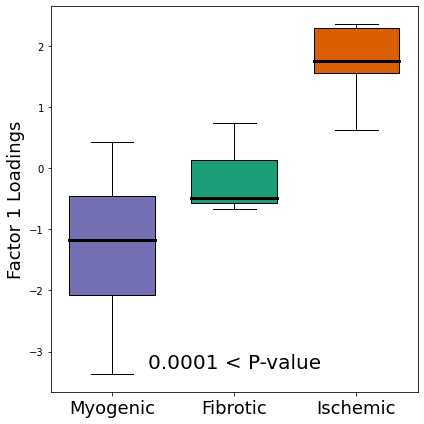

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(6, 6))
box_positions = np.arange(1, len(labels) + 1)

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)
# Add ANOVA significance if p-value is significant (typically p < 0.05)
plt.text(2, min([group.min() for group in groups]) + 0.1, f'{pval+ 0.0001:.4f} < P-value', ha='center', fontsize=20)

# Set labels and title
plt.xlabel('')
plt.ylabel('Factor 1 Loadings', fontsize=18)  # Adjusted font size
plt.title('')
plt.xticks(box_positions, labels, fontsize=18)  # Adjusted font size
plt.tight_layout()

# Show the plot
plt.show()


In [31]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [32]:
variable_loadings.to_csv('kuppe_visium/kuppe_mofa_loadings.csv')

In [33]:
# target = Myeloid and source = Fibroblast
myeloid_loadings = variable_loadings[(variable_loadings['source']=='Myeloid') & (variable_loadings['target']=='Endothelial')]

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


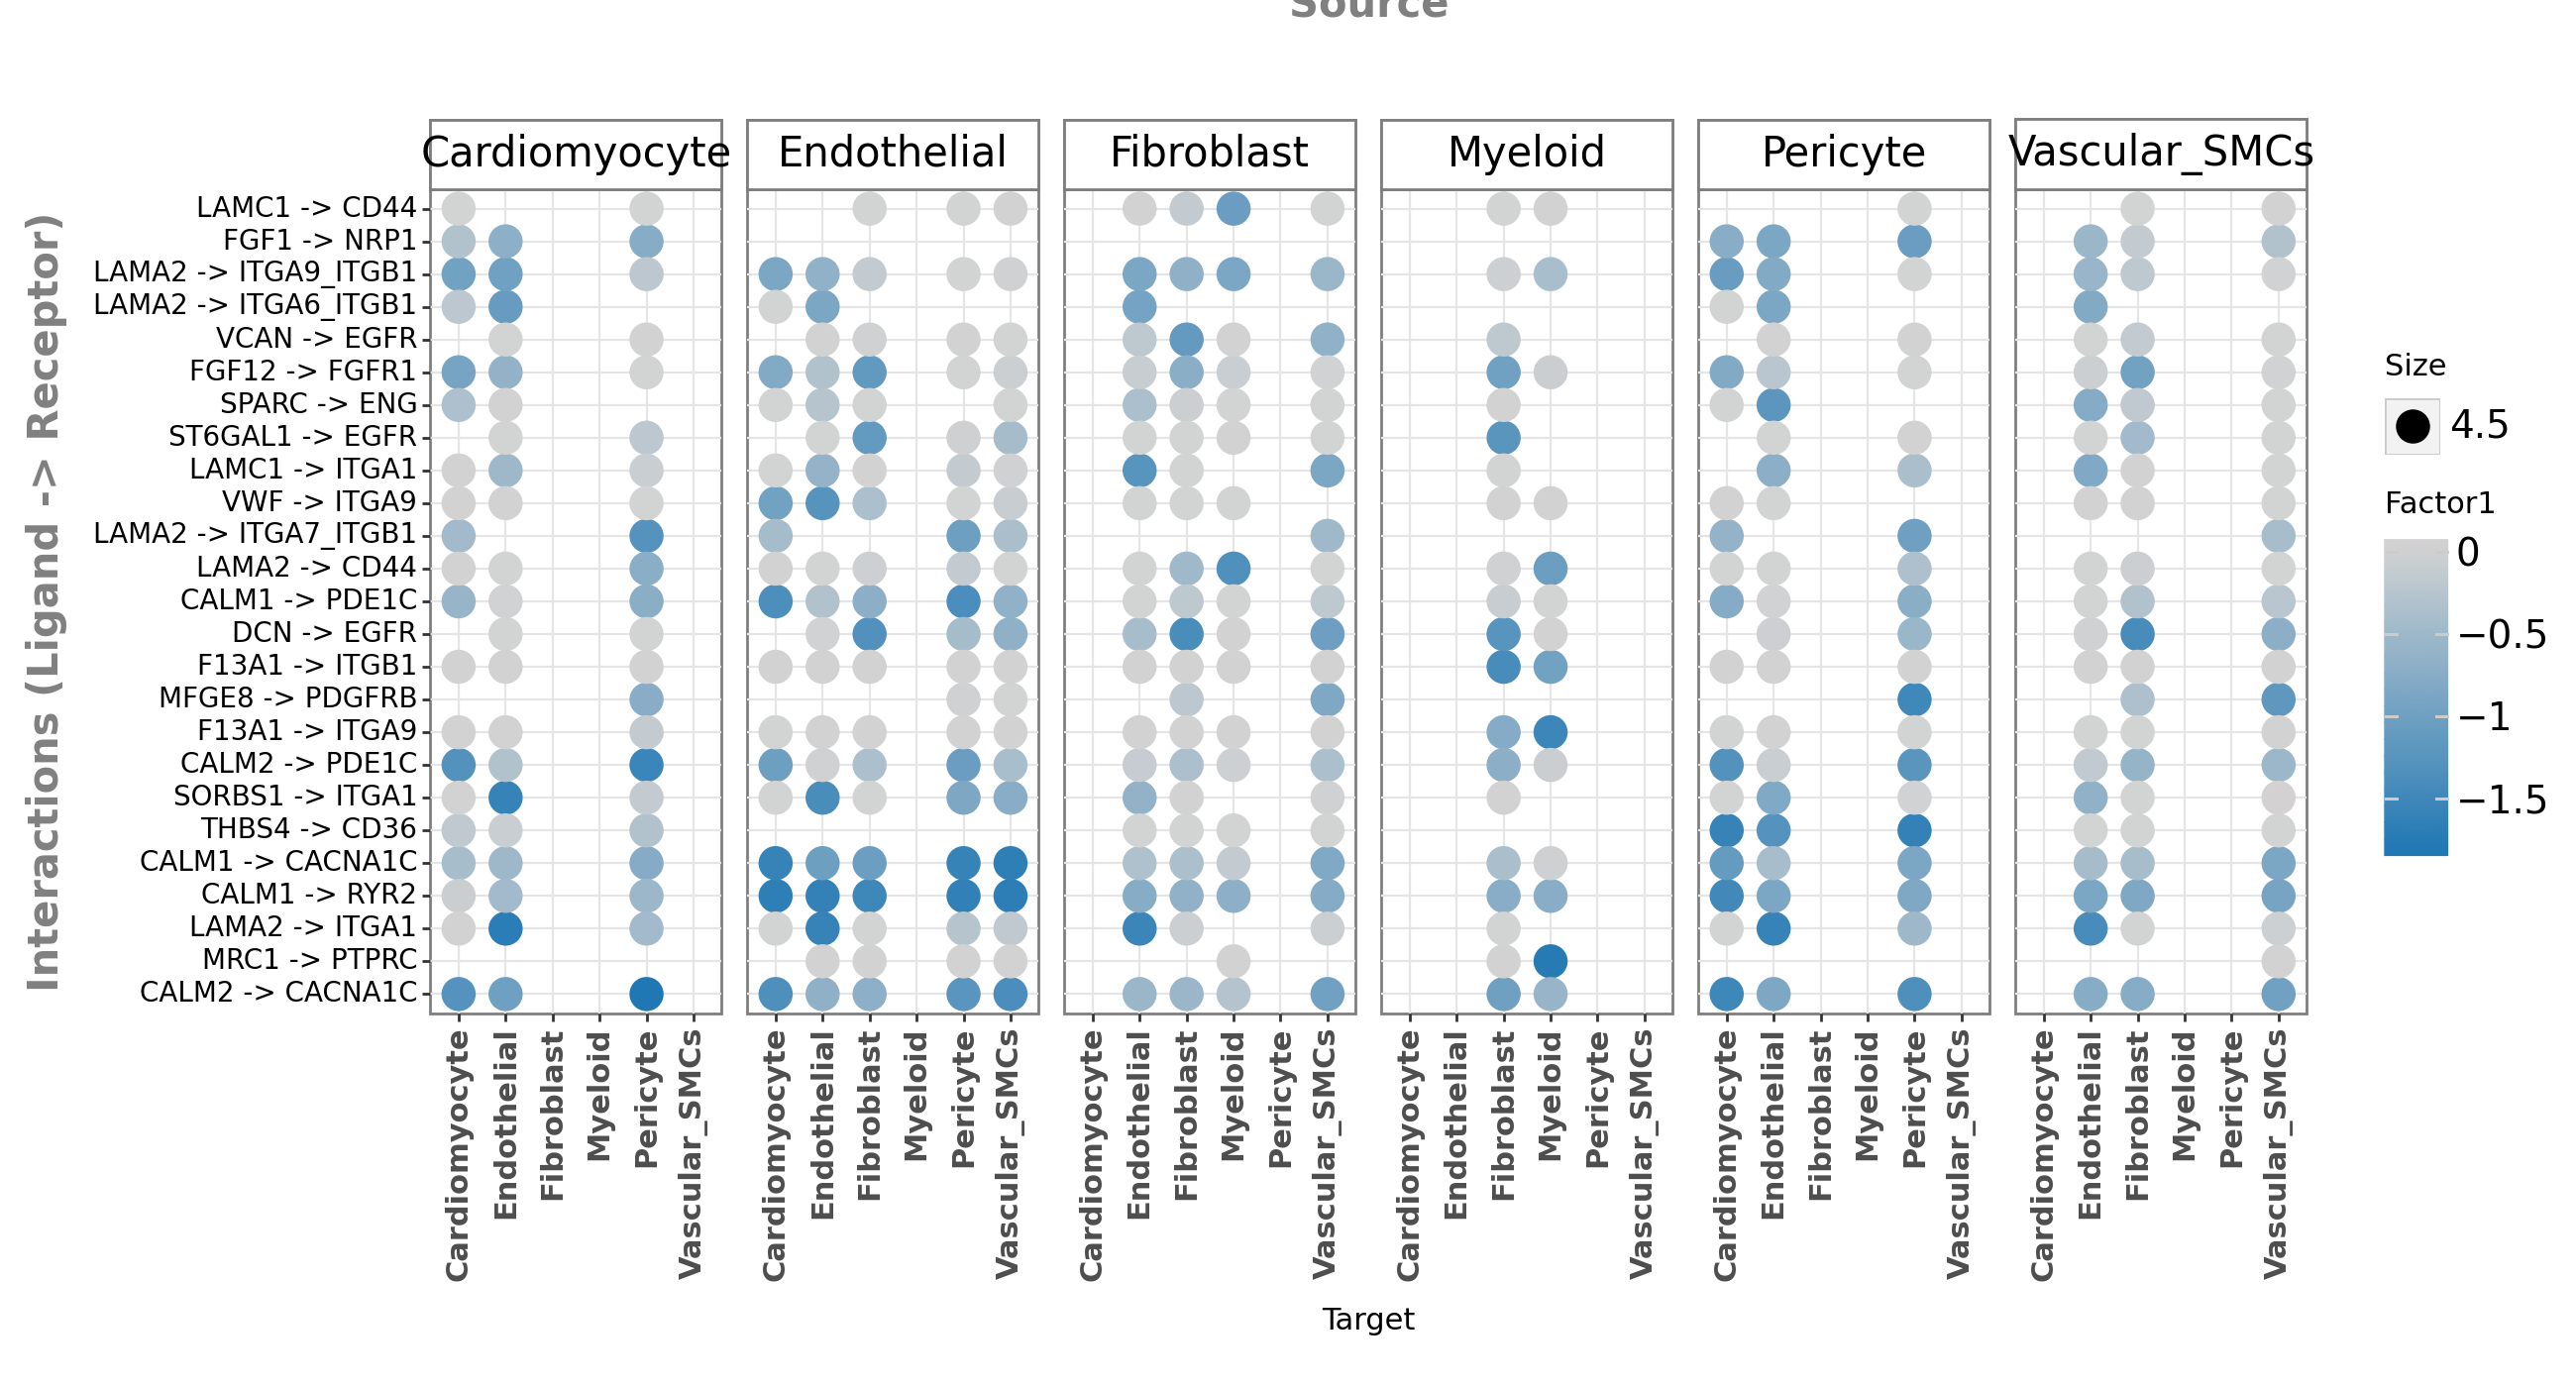

<Figure Size: (1300 x 700)>

In [34]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        top_n=25,
                        orderby_absolute=True,
                        orderby_ascending=False,
                        size_range=(0.1, 6),
                        figure_size=(13, 7)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)

In [35]:
# import omnipath as op
# inter = op.interactions.import_intercell_network()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


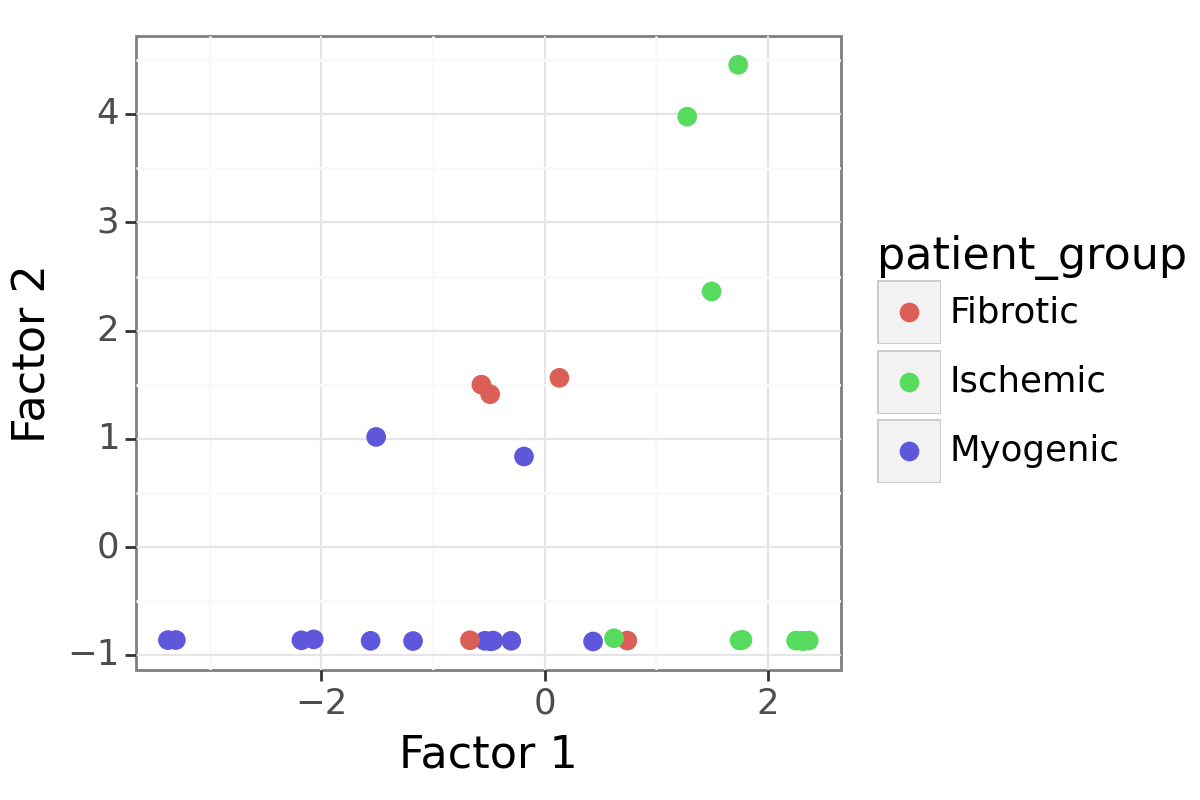

<Figure Size: (600 x 400)>

In [36]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [37]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


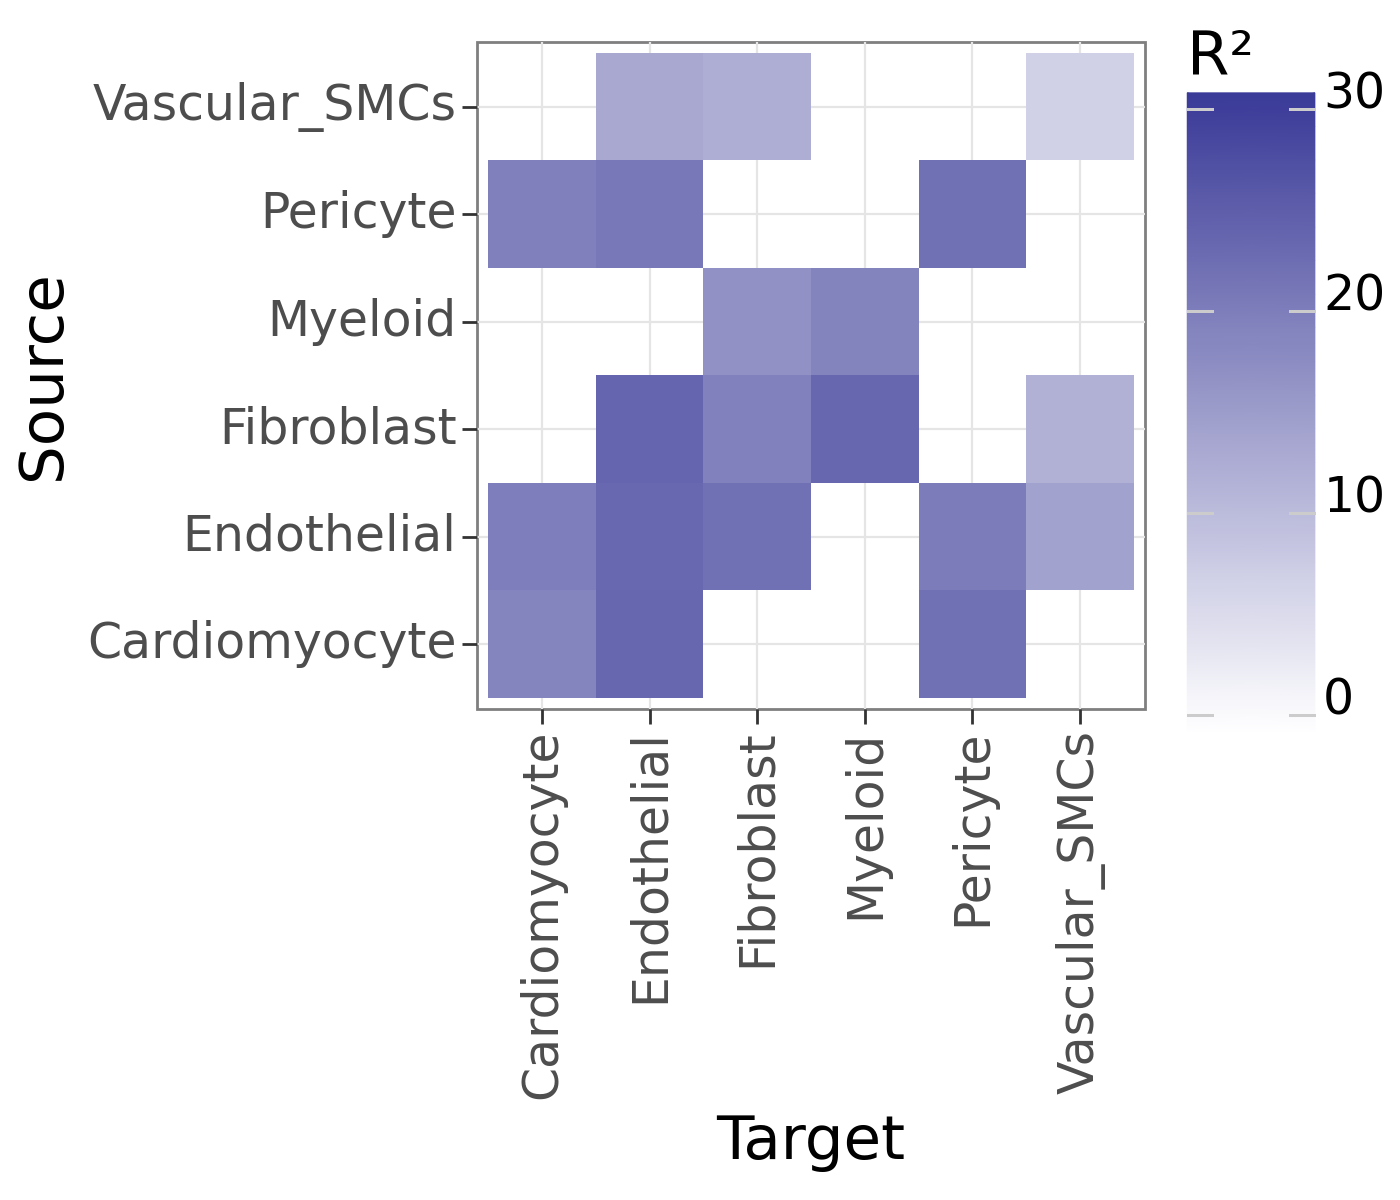

<Figure Size: (700 x 600)>

In [38]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
#  p9.scale_fill_gradient2(low='white', high='#c20019') +
# limits 
    p9.scale_fill_gradient2(limits=(0, 30)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(7,6))
)

In [39]:
ct_int = variable_loadings[(variable_loadings['source']=='Cardiomyocyte') & (variable_loadings['target']=='Endothelial')]

In [40]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [41]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(20)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank
439,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.683287,-0.080034,-0.001442,-0.034849,-0.031152,-0.008503,-0.015499,0.037038,-0.007359,-0.024533,4.5,241.0
492,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.569262,-0.047901,0.005704,-0.009361,-0.041407,-0.011891,-0.029675,0.049430,-0.016950,-0.052091,4.5,240.0
440,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.071832,0.141395,0.029869,0.130550,0.026099,0.003877,-0.015019,-0.014182,0.001767,-0.026675,4.5,239.0
337,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-0.983652,-0.029200,0.001228,-0.031485,0.086535,0.000678,-0.036201,-0.016968,0.052258,0.126843,4.5,238.0
441,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-0.975422,0.042017,0.071796,0.077706,0.024963,0.030245,-0.015103,-0.082836,0.006953,-0.021926,4.5,237.0
411,FGF1,NRP1,Cardiomyocyte,Endothelial,-0.698753,-0.122379,0.001058,-0.097499,-0.097785,-0.006773,0.022319,0.070767,-0.035193,-0.058176,4.5,236.0
408,FGF12,FGFR1,Cardiomyocyte,Endothelial,-0.639291,0.007112,0.141429,-0.010308,-0.136888,-0.001537,0.024666,-0.047763,-0.017641,-0.056495,4.5,235.0
509,TGM2,ITGA9,Cardiomyocyte,Endothelial,-0.632639,0.019790,0.208005,-0.074880,0.060506,-0.001587,-0.090838,-0.050154,0.046184,0.098063,4.5,234.0
307,ADAM9,ITGA6,Cardiomyocyte,Endothelial,-0.599924,-0.042405,-0.028906,0.023985,-0.005402,-0.003089,0.038487,0.102380,-0.022042,-0.088352,4.5,233.0
455,LAMC1,ITGA1,Cardiomyocyte,Endothelial,-0.525452,-0.050158,-0.049432,0.007564,-0.092846,-0.001873,-0.007216,0.050365,-0.017064,-0.025678,4.5,232.0


In [42]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [43]:
ct_int.sort_values("Factor1")

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
439,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.683287,-0.080034,-0.001442,-0.034849,-0.031152,-0.008503,-0.015499,0.037038,-0.007359,-0.024533,4.5,241.0,
492,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.569262,-0.047901,0.005704,-0.009361,-0.041407,-0.011891,-0.029675,0.049430,-0.016950,-0.052091,4.5,240.0,
440,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.071832,0.141395,0.029869,0.130550,0.026099,0.003877,-0.015019,-0.014182,0.001767,-0.026675,4.5,239.0,LAMA2 -> ITGA6_ITGB1
337,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-0.983652,-0.029200,0.001228,-0.031485,0.086535,0.000678,-0.036201,-0.016968,0.052258,0.126843,4.5,238.0,
441,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-0.975422,0.042017,0.071796,0.077706,0.024963,0.030245,-0.015103,-0.082836,0.006953,-0.021926,4.5,237.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,COL18A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,0.015576,-0.001265,0.045718,0.001841,0.001020,-0.000741,-0.036779,-0.021466,-0.012637,-0.015329,4.5,5.0,
407,FBN1,ITGB1,Cardiomyocyte,Endothelial,0.016615,0.008637,0.009746,0.017595,0.010038,-0.000475,-0.054604,-0.025131,0.010401,0.043309,4.5,4.0,
379,COL3A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,0.016953,0.071610,0.006793,1.849145,-0.017459,-0.000084,-0.024144,-0.055172,0.050613,-0.028970,4.5,3.0,
472,NAMPT,INSR,Cardiomyocyte,Endothelial,0.047804,0.204685,0.062366,0.307477,0.095882,0.042656,0.010138,-0.054049,-0.060853,-0.022290,4.5,2.0,


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


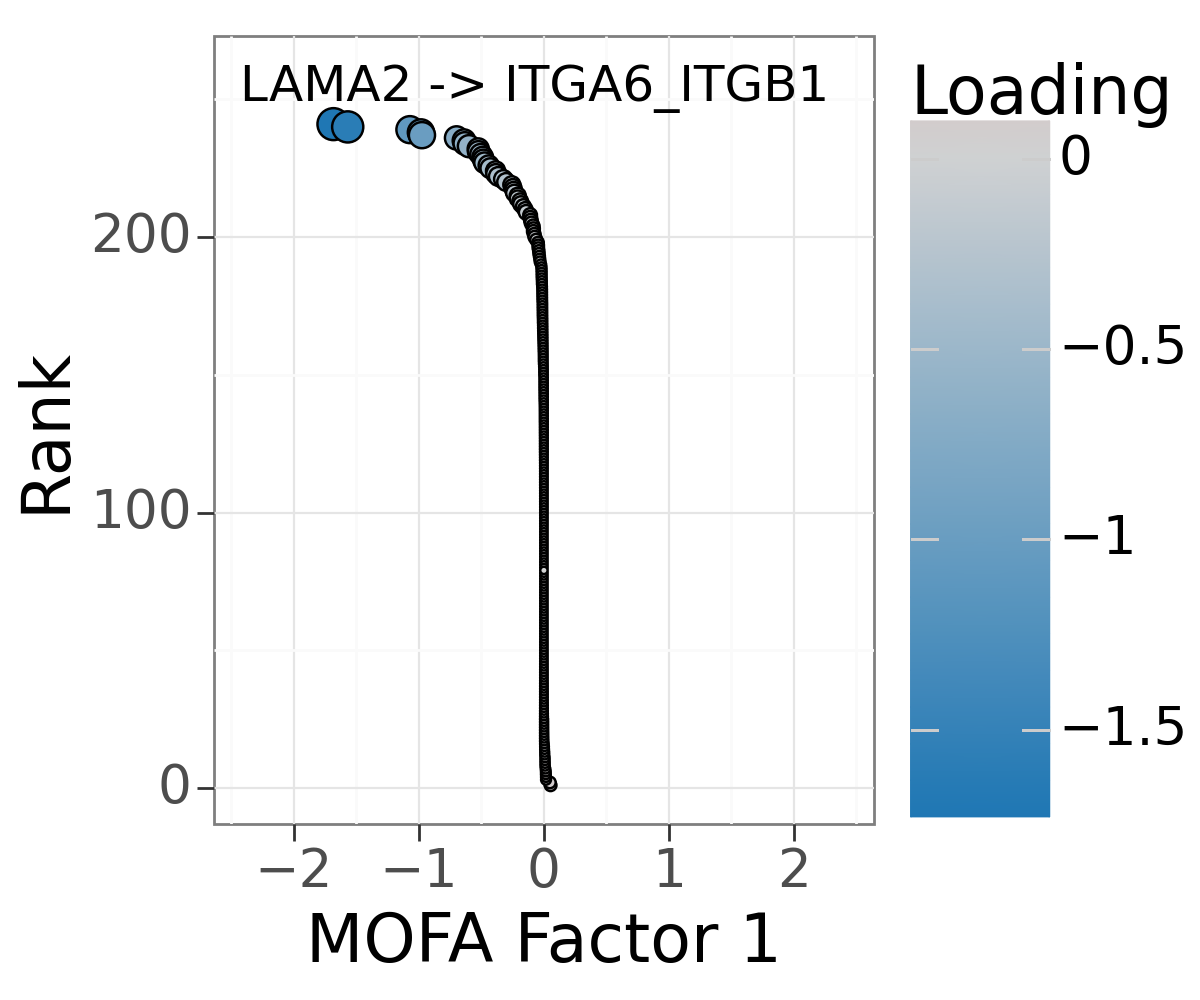

<Figure Size: (600 x 500)>

In [44]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 260)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

In [45]:
ct_int.sort_values("Factor1", key=abs, ascending=False)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
439,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.683287e+00,-8.003350e-02,-1.442085e-03,-3.484913e-02,-3.115216e-02,-8.502853e-03,-1.549879e-02,3.703796e-02,-7.358946e-03,-2.453315e-02,1.683287e+00,241.0,
492,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.569262e+00,-4.790053e-02,5.704102e-03,-9.361362e-03,-4.140653e-02,-1.189119e-02,-2.967531e-02,4.943028e-02,-1.695041e-02,-5.209082e-02,1.569262e+00,240.0,
440,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.071832e+00,1.413947e-01,2.986923e-02,1.305496e-01,2.609898e-02,3.877093e-03,-1.501863e-02,-1.418245e-02,1.767068e-03,-2.667459e-02,1.071832e+00,239.0,LAMA2 -> ITGA6_ITGB1
337,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-9.836519e-01,-2.919964e-02,1.227665e-03,-3.148522e-02,8.653534e-02,6.780807e-04,-3.620062e-02,-1.696794e-02,5.225781e-02,1.268431e-01,9.836519e-01,238.0,
441,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-9.754222e-01,4.201748e-02,7.179590e-02,7.770648e-02,2.496307e-02,3.024529e-02,-1.510293e-02,-8.283625e-02,6.952823e-03,-2.192584e-02,9.754222e-01,237.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,THBS2,CD36,Cardiomyocyte,Endothelial,-2.817880e-09,-9.889627e-08,4.047319e-08,1.311557e-01,8.140942e-07,2.843806e-09,4.804835e-07,3.586225e-07,-1.123899e-06,-3.047136e-07,2.817880e-09,81.0,
325,B2M,TFRC,Cardiomyocyte,Endothelial,2.162443e-09,-1.537863e-08,2.119985e-02,-2.076693e-08,-8.045603e-07,-1.070188e-09,-5.891131e-07,-3.629957e-01,1.114387e-07,6.113434e-08,2.162443e-09,77.0,
442,LAMA4,CD44,Cardiomyocyte,Endothelial,8.250932e-10,2.331776e-02,9.515054e-07,3.711515e-08,3.716824e-02,-1.260667e-10,-1.845514e-06,2.458111e-06,-1.691105e-01,-1.071500e-06,8.250932e-10,78.0,
397,COL8A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,-6.630398e-10,-2.331785e-07,1.221325e-01,2.413228e-01,-5.277298e-07,8.699812e-09,-4.356936e-01,-5.127794e-01,8.048414e-02,3.059814e-07,6.630398e-10,80.0,


PyDESeq2

In [46]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
# import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from matplotlib import pyplot as plt


AnnData

In [47]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

Create Pseudobulk

In [48]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 167 × 26854
    obs: 'sample', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    layers: 'psbulk_props'

In [49]:
pdata.obs = pdata.obs[[sample_key, groupby, condition_key, "patient_region_id", "major_labl", "cell_type", "psbulk_n_cells", "psbulk_counts"]]

In [50]:
pdata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_pseudobulk.h5ad'))

... storing 'sample' as categorical
... storing 'cell_type_original' as categorical
... storing 'patient_group' as categorical
... storing 'patient_region_id' as categorical
... storing 'major_labl' as categorical
... storing 'cell_type' as categorical


: 

Normalize

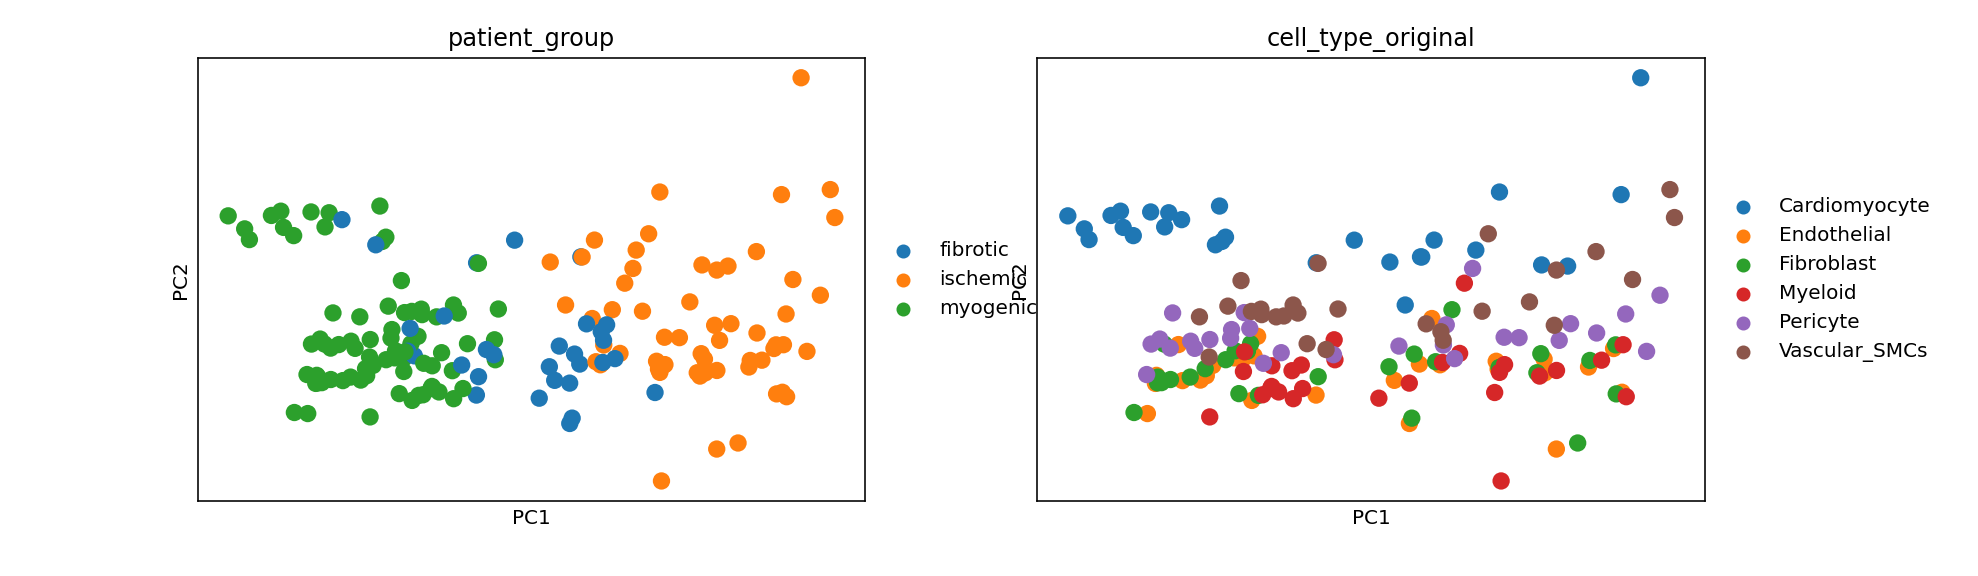

In [48]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

sc.pl.pca(pp_pdata, color=[condition_key, groupby], ncols=2, show=True, size=300)

In [49]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = [groupby, condition_key], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)



100%|██████████| 10/10 [00:00<00:00, 34.90it/s]


Starting plotting HeatmapAnnotations


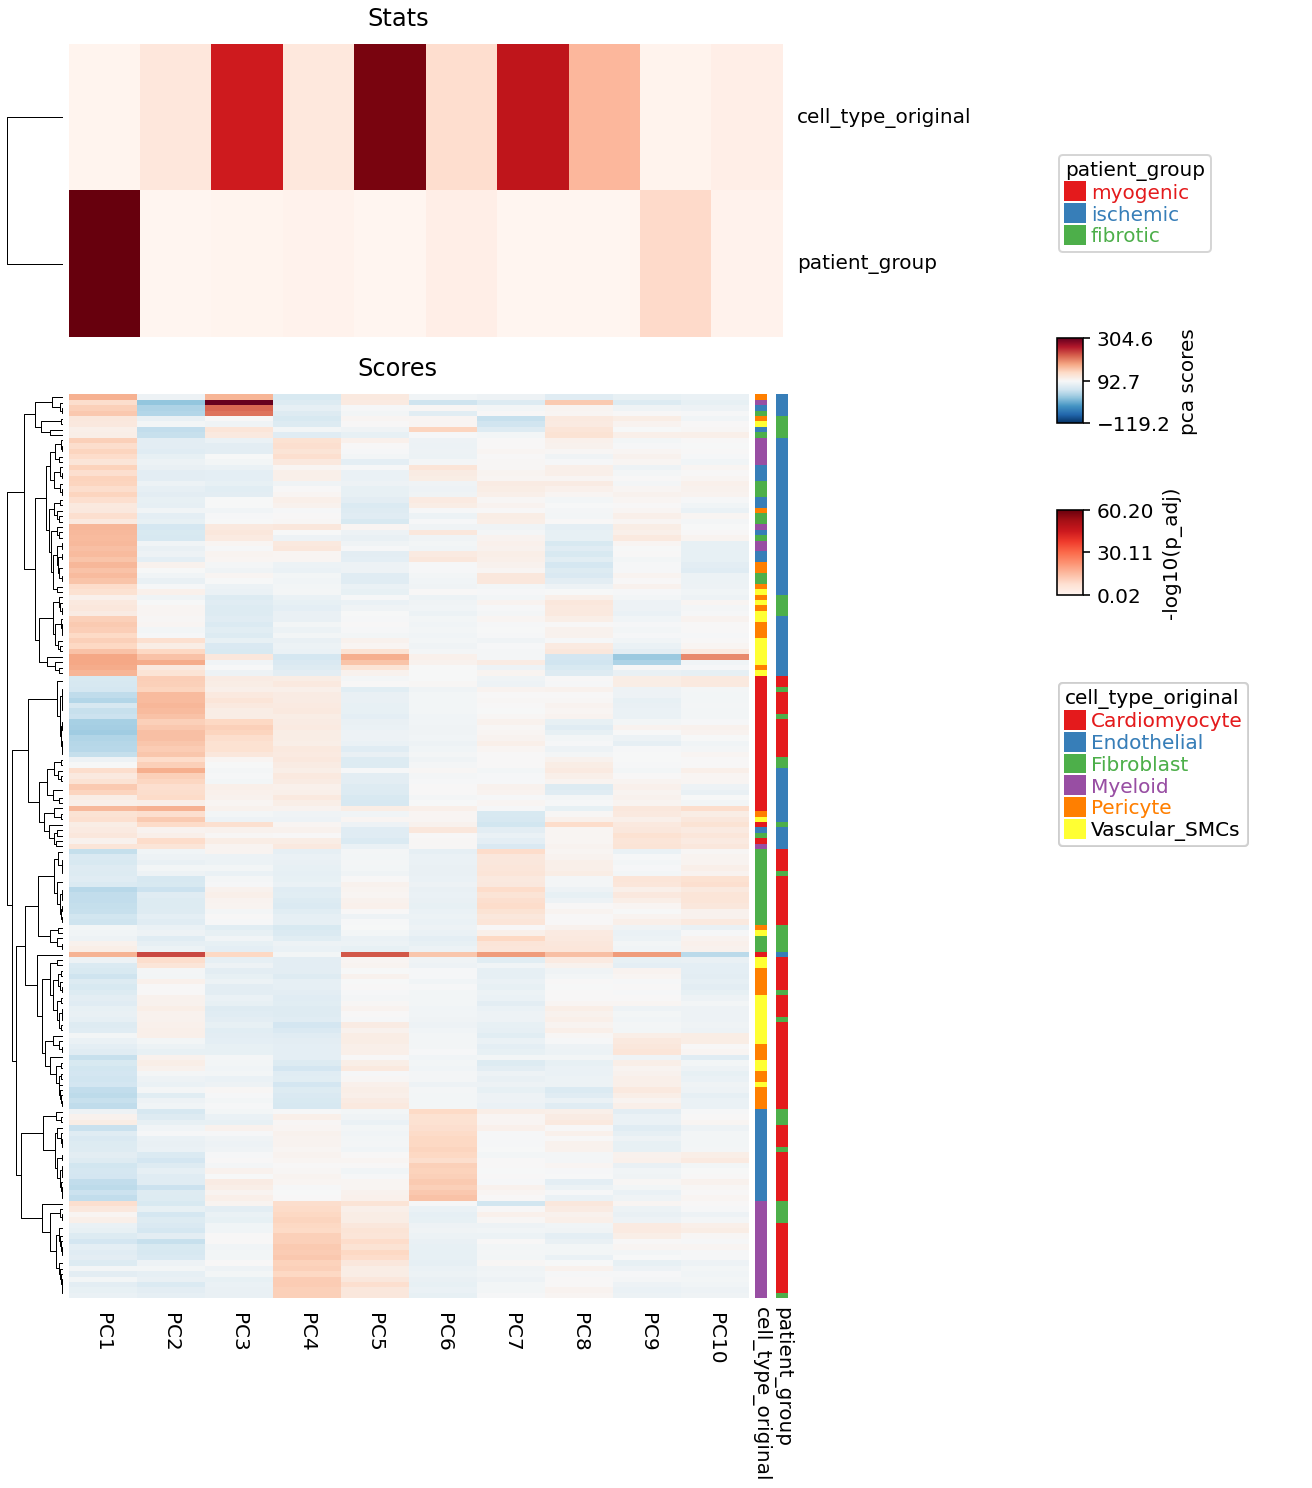

In [50]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova',  # summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # which summary statistic to plot
    obs_annotation_cols = [groupby, condition_key], # which sample annotations to plot
)
plt.show()

In [51]:
# IZ vs Rest
pdata.obs['condition'] = 'Rest' # TODO: do on adata
pdata.obs.loc[pdata.obs[condition_key]=='ischemic', 'condition'] = 'IZ'

In [52]:
condition_key = 'condition'
ref = "Rest"
cond = "IZ"

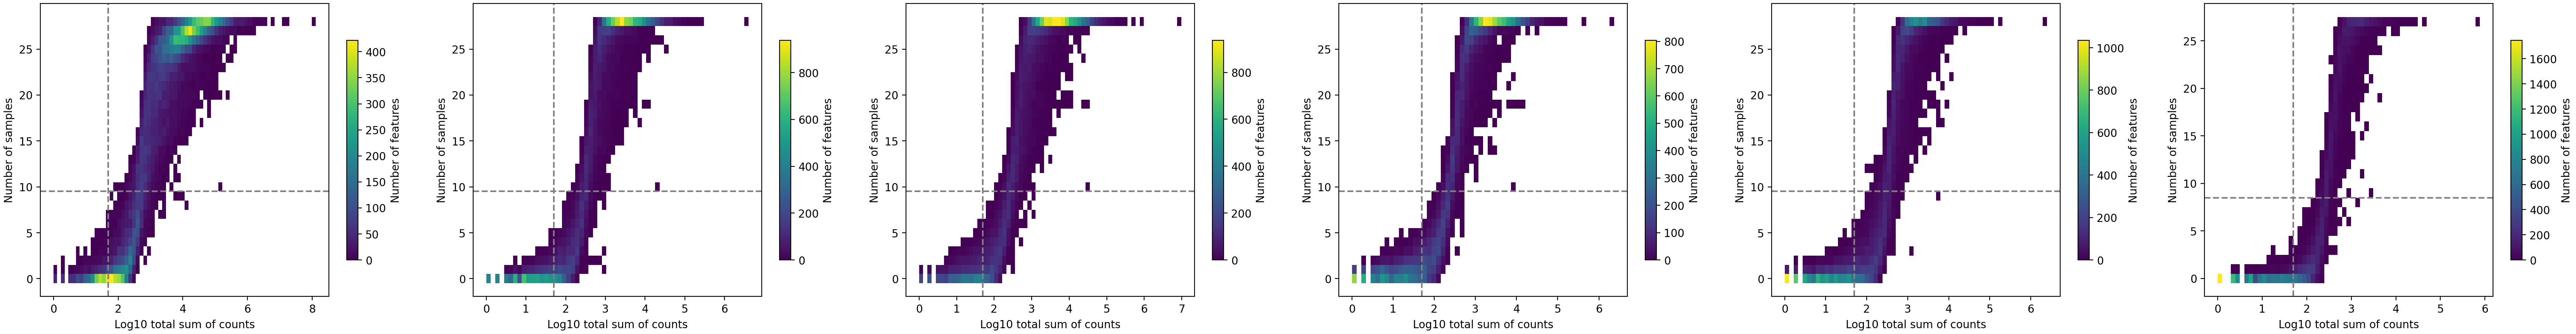

In [53]:
min_count = 10
min_total_count = 50
large_n = 10
min_prop = 0.2

# plt with ax with same number as groups
fig, axes = plt.subplots(1, len(pdata.obs[groupby].unique()), figsize=(7*len(pdata.obs[groupby].unique()), 5))

for i, cell_group in enumerate(pdata.obs[groupby].unique()):
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n, min_prop=min_prop, ax =axes[i])

In [54]:
%%capture
dea_results = {}


for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=10, min_total_count=20, large_n=5)

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=min_count,
                              min_total_count=min_total_count,
                              large_n=large_n,
                              min_prop=min_prop
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Rest'],
        refit_cooks=True,
        n_cpus=None,
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, cond, ref], n_cpus=8)
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff=f'{condition_key}_{cond}_vs_{ref}') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [55]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby})
dea_df.set_index('feature_name', inplace=True)
dea_df.to_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'))

In [56]:
dea_df.head()

,cell_type_original,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
feature_name,,,,,,,
A1BG,Cardiomyocyte,3.283124,0.201507,0.462684,1.128359,2.591684e-01,0.338188
A1BG-AS1,Cardiomyocyte,14.546547,2.334501,0.538542,4.982959,6.261916e-07,0.000005
A1CF,Cardiomyocyte,7.187088,-5.229283,2.725455,-1.735727,8.261214e-02,0.129245
A2M,Cardiomyocyte,663.467224,-0.849649,0.420243,-2.301950,2.133798e-02,0.040415
A2M-AS1,Cardiomyocyte,23.810741,-1.484246,0.524430,-2.966605,3.011079e-03,0.007487


Read DEA Results

In [57]:
dea_df = pd.read_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'), index_col=0)

In [58]:
# keep only iz
adata_s = adata[adata.obs['patient_group']=='ischemic', :] # change to condition key when in adata

In [59]:
adata_s = adata_s.to_memory()

In [60]:
adata_s.X = adata_s.layers['counts'].copy()


In [61]:
adata_s.X.max()

4559.0

In [62]:
sc.pp.normalize_total(adata_s)
sc.pp.log1p(adata_s)
# NOTE: it's not already log-transformed (its something with the way it's saved)

In [63]:
lr_res = li.multi.df_to_lr(adata_s,
                           dea_df=dea_df,
                           resource=resource,
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using `.X`!
3970 features of mat are empty, they will be removed.


Using provided `resource`.


['RMRP_ENSG00000269900', 'ALG1L9P_ENSG00000248671', 'RP11-436O19__A.6', 'LINC01830_ENSG00000234207', 'LINC00486_ENSG00000230876', 'SLFN12L_ENSG00000205045', 'POLR2J3_ENSG00000285437', 'SIGLEC5_ENSG00000105501', 'DNAJC9-AS1_ENSG00000227540', 'ITFG2-AS1_ENSG00000258325', 'FAM153B_ENSG00000182230', 'RAET1E-AS1_ENSG00000268592', 'PINX1_ENSG00000254093', 'SPATA13_ENSG00000182957', 'DUXAP8_ENSG00000206195', 'DGCR5_ENSG00000273032', 'RP4-633O19__A.1', 'LINC00941_ENSG00000285517', 'DNAJC9-AS1_ENSG00000236756', 'LINC00486_ENSG00000236854', 'RNU11_ENSG00000270103', 'CLCA4-AS1_ENSG00000236915', 'RP11-99J16__A.2', 'LINC01115_ENSG00000237667', 'LINC01605_ENSG00000253161', 'XXyac-YX65C7_A.2', 'LINC01830_ENSG00000228999', 'RPPH1_ENSG00000259001', 'PRICKLE2-AS1_ENSG00000241111', 'RP1-213J1P__B.1', 'CCDC39_ENSG00000284862', 'SCARNA2_ENSG00000270066', 'RGS5_ENSG00000232995', 'RP11-1157N2__B.2', 'RNU12_ENSG00000270022', 'RGS5_ENSG00000143248', 'PROX1-AS1_ENSG00000230461', 'PDE11A_ENSG00000128655', 'MAFIP

TODO: Enable Filtering

In [64]:
ints = pd.DataFrame(index=model.views)

In [65]:
# split index by & into source and target
ints[['source', 'target']] = list(ints.index.str.split('&', 1, expand=True))

In [66]:
ints

,source,target
Cardiomyocyte&Cardiomyocyte,Cardiomyocyte,Cardiomyocyte
Cardiomyocyte&Endothelial,Cardiomyocyte,Endothelial
Cardiomyocyte&Pericyte,Cardiomyocyte,Pericyte
Endothelial&Cardiomyocyte,Endothelial,Cardiomyocyte
Endothelial&Endothelial,Endothelial,Endothelial
Endothelial&Fibroblast,Endothelial,Fibroblast
Endothelial&Pericyte,Endothelial,Pericyte
Endothelial&Vascular_SMCs,Endothelial,Vascular_SMCs
Fibroblast&Endothelial,Fibroblast,Endothelial
Fibroblast&Fibroblast,Fibroblast,Fibroblast


In [67]:
# NOTE inner join with interactions
lr_res = lr_res.merge(ints, on=['source', 'target'], how='inner')

Pick interactions of interst based on R2

In [68]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='interaction_expr',
                     inverse_size=False,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=25,
                     size_range=(0.1, 6)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, + limits for colour and mid point
    + p9.scale_color_cmap('RdBu_r', limits=(-5, 5), midpoint=0)
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(13, 7)) +
    p9.labs(color='Wald Statistic', size='Normalised Expression')
)

ValueError: `interaction_expr` (size) must be one of Index(['ligand', 'receptor', 'ligand_complex', 'receptor_complex', 'source',
       'ligand_stat', 'ligand_pvalue', 'ligand_padj', 'ligand_expr',
       'ligand_props', 'target', 'receptor_stat', 'receptor_pvalue',
       'receptor_padj', 'receptor_expr', 'receptor_props', 'interaction_stat',
       'interaction_pvalue', 'interaction_padj', 'interaction'],
      dtype='object')

Save DE interactions -> go space

In [ ]:
lr_res.to_csv(os.path.join('kuppe_visium', 'kuppe_dea_interactions.csv'), index=False)

TFs

In [ ]:
net = dc.get_collectri(organism='human')

In [ ]:
from decoupler import p_adjust_fdr

In [ ]:
acts = {}

for cell_group in pdata.obs[groupby].unique():
    ct_df = dea_df[dea_df[groupby] == cell_group].copy()
    mat = ct_df[['stat']].T.rename(index={'stat': cell_group})
    
    # Infer pathway activities with ulm
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
    tf_acts = tf_acts.T.rename(columns={cell_group: 'activity'})
    tf_pvals = tf_pvals.T.rename(columns={cell_group: 'pvalue'})
    
    act = tf_acts.merge(tf_pvals, left_index=True, right_index=True)
    acts[cell_group] = act
    

In [ ]:
acts = pd.concat(acts)

In [ ]:
acts['fdr'] = p_adjust_fdr(acts['pvalue'])
acts = acts.reset_index(names=[groupby, 'tf'])

In [ ]:
acts.to_csv(os.path.join('kuppe_visium', 'kuppe_tf_activities.csv'), index=False)

In [ ]:
acts.sort_values("fdr").head()

,cell_type_original,tf,activity,pvalue,fdr
517,Cardiomyocyte,SP1,10.001782,1.726301e-23,6.111107e-20
248,Cardiomyocyte,JUN,8.698586,3.648352e-18,6.457583e-15
360,Cardiomyocyte,NFKB,8.179969,3.028394e-16,3.573505e-13
4,Cardiomyocyte,AP1,8.019044,1.131235e-15,1.001143e-12
1354,Fibroblast,E2F1,7.475995,8.055968e-14,5.703625e-11


Check CPDB

In [ ]:
import omnipath as op

In [ ]:
cpdb = op.interactions.import_intercell_network(interactions_params={'databases': ['CellPhoneDB'], 'genesymbols':True}, transmitter_params={'databases': ['CellPhoneDB']}, receiver_params={'databases': ['CellPhoneDB']})

In [ ]:
cpdb[['source_genesymbol', 'target_genesymbol']].drop_duplicates()